## Лабораторная работа №4

### Хахин Максим М8О-403Б-18

Используя схемы переменных направлений и дробных шагов, решить двумерную начально-краевую задачу для дифференциального уравнения параболического типа. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением U(x, t). Исследовать зависимость погрешности от сеточных параметров ta

![title](lab4.png)

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [26]:
a = 1
b = 1

lx = 1
ly = 1
lt = 5
omega = 1.5
nx = 100
ny = 100
nt = 100
eps = 0.001

u0yt = lambda y, t: 0
ulyt = lambda y, t: 0
ux0t = lambda x, t: 0
uxlt = lambda x, t: 0
uxy0 = lambda x, y: x*y
f = lambda x, y, t: -x*y*np.sin(t)

fResult = lambda x, y, t: x*y*np.cos(t)

alpha1 = 1
betta1 = -1
alpha2 = 1
betta2 = -1

hx = lx / nx
hy = ly / ny
ht = lt / nt

tt = 3
yy = 3
U = []


In [27]:
def plotSlice(f, X, y, t):
    plt.subplot(2, 1, 1)
    plt.plot(X, f(X, y, t))
    plt.grid


def showPostProcess(t, y):
    i = 2
    X = np.linspace(0, lx, nx)
    plotSlice(fResult, X, y * hy, ht * t * 2)
    plt.subplot(2, 1, 1)
    plt.plot(X, U[i*t, :, y])


def Error(U, fR):
    i = 2
    X = np.linspace(0, lx, nx)
    Y = np.linspace(0, ly, ny)
    T = list(range(0, int(U.shape[0]/2)))
    plt.subplot(2, 1, 2)
    XX, YY = np.meshgrid(X, Y)
    plt.plot(T, list(map(lambda t: np.max(np.abs(U[i*t] - np.transpose(fR(XX, YY, ht * t * i)))), T)))


def gridFun(iCond, bCond):
    xCond, yCond = bCond
    xlCond, xrCond = xCond
    ylCond, yrCond = yCond
    tlCond, trCond = iCond
    return np.zeros((trCond, xrCond, yrCond))

In [28]:
def parabolicEquation2D(iCond, bCond, method):

    def init():
        for m in range(nx):
            for n in range(ny):
                U[0][m][n] = uxy0(m * hx, n * hy)

    def solve():
        for k in range(0, nt - i, i):
            for n in range(1, ny - 1):
                A1 = getA1(k, n)
                B1 = getB1(k, n)
                U[int(k + i / 2), :, n] = np.linalg.solve(A1, B1)[:, 0]
            for m in range(1, nx - 1):
                A2 = getA2(k, m)
                B2 = getB2(k, m)
                U[k + i, m, :] = np.linalg.solve(A2, B2)[:, 0]
            for n in range(0, ny):
                U[k + i][0][n] = (u0yt(n * hy, (k + i) * ht) - c1 * U[k + i][1][n]) / b1
                U[k + i][nx - 1][n] = (ulyt(n * hy, (k + i) * ht) - aN1 * U[k + i][nx - 2][n]) / bN1

    def FractionSteps():

        aj1 = -a/hx**2
        bj1 = 1/ht/2 + 2*a/hx**2
        cj1 = -a/hx**2

        aj2 = -b/hy**2
        bj2 = 1/ht/2 + 2*b/hy**2
        cj2 = -b/hy**2

        def gA1(k, n):
            aa = np.zeros((nx, nx))
            aa[0][0] = b1
            aa[0][1] = c1
            for j in range(1, nx - 1):
                aa[j][j - 1] = aj1
                aa[j][j] = bj1
                aa[j][j + 1] = cj1
            aa[nx - 1][nx - 2] = aN1
            aa[nx - 1][nx - 1] = bN1
            return aa

        def gB1(k, n):
            bb = np.zeros((nx, 1))
            bb[0][0] = u0yt(n * hy, ht * (k + i))
            bb[nx - 1][0] = ulyt(n * hy, ht * (k + i))
            for m in range(1, nx - 1):
                bb[m][0] = f(m * hx, n * hy, k * ht)/2 + U[k][m][n] / ht / 2
            return bb

        def gA2(k, m):
            aa = np.zeros((ny, ny))
            aa[0][0] = b2
            aa[0][1] = c2
            for j in range(1, ny - 1):
                aa[j][j - 1] = aj2
                aa[j][j] = bj2
                aa[j][j + 1] = cj2
            aa[ny - 1][ny - 2] = aN2
            aa[ny - 1][ny - 1] = bN2
            return aa

        def gB2(k, m):
            bb = np.zeros((ny, 1))
            bb[0][0] = ux0t(m * hx, ht * (k + i))
            bb[ny - 1][0] = uxlt(m * hx, ht * (k + i))
            for n in range(1, ny - 1):
                bb[n][0] = f(m * hx, n * hy, (k + i) * ht)/2 + U[int(k + i/2)][m][n] / ht / 2
            return bb
        return (gA1, gB1), (gA2, gB2)

    def AlternatingDirection():

        aj1 = -a / hx ** 2
        bj1 = 1 / ht + 2 * a / hx ** 2
        cj1 = -a / hx ** 2

        aj2 = -b / hy ** 2
        bj2 = 1 / ht + 2 * b / hy ** 2
        cj2 = -b / hy ** 2

        def gA1(k, n):
            aa = np.zeros((nx, nx))
            aa[0][0] = b1
            aa[0][1] = c1
            for j in range(1, nx - 1):
                aa[j][j - 1] = aj1
                aa[j][j] = bj1
                aa[j][j + 1] = cj1
            aa[nx - 1][nx - 2] = aN1
            aa[nx - 1][nx - 1] = bN1
            return aa

        def gB1(k, n):
            bb = np.zeros((nx, 1))
            bb[0][0] = u0yt(n * hy, ht * (k + i))
            bb[nx - 1][0] = ulyt(n * hy, ht * (k + i))
            for m in range(1, nx - 1):
                bb[m][0] = f(m * hx, n * hy, int(k + i/2) * ht) + (1 / ht - 2*b/ hy**2) * U[k][m][n] + (b/hy**2) * (U[k][m][n + 1] + U[k][m][n - 1])
            return bb

        def gA2(k, m):
            aa = np.zeros((ny, ny))
            aa[0][0] = b2
            aa[0][1] = c2
            for j in range(1, ny - 1):
                aa[j][j - 1] = aj2
                aa[j][j] = bj2
                aa[j][j + 1] = cj2
            aa[ny - 1][ny - 2] = aN2
            aa[ny - 1][ny - 1] = bN2
            return aa

        def gB2(k, m):
            bb = np.zeros((ny, 1))
            bb[0][0] = ux0t(m * hx, ht * (k + i))
            bb[ny - 1][0] = uxlt(m * hx, ht * (k + i))
            for n in range(1, ny - 1):
                bb[n][0] = f(m * hx, n * hy, int(k + i/2) * ht) + (1 / ht - 2*a/ hx**2) * U[int(k + i/2)][m][n] + (a/hx**2) * (U[int(k + i/2)][m + 1][n] + U[int(k + i/2)][m - 1][n])
            return bb

        return (gA1, gB1), (gA2, gB2)
    if method == 1:
        (getA1, getB1), (getA2, getB2) = AlternatingDirection()
    elif method == 2:
        (getA1, getB1), (getA2, getB2) = FractionSteps()
    else:
        pass
    b1 = 1
    c1 = 0
    b2 = 1
    c2 = 0

    aN1 = -betta1 / hx
    bN1 = alpha1 + betta1 / hx
    aN2 = -betta2 / hy
    bN2 = alpha2 + betta2 / hy

    uxy0 = iCond
    xCond, yCond = bCond
    u0yt, ulyt = xCond
    ux0t, uxlt = yCond
    U = gridFun((0, nt), ((0, nx), (0, ny)))
    i = 2
    init()
    solve()
    return U

In [29]:
def solver():
    global a, b, nx, ny, nt, hx, hy, ht, U, tt, yy
    i = 2
    a = a
    b = b
    nx = nx
    ny = ny
    nt = 2 * nt
    tt = tt
    yy = yy
    hx = lx / nx
    hy = ly / ny
    ht = lt / nt
    nx += 1
    ny += 1
    nt += i
    U = []

Метод Переменных направлений

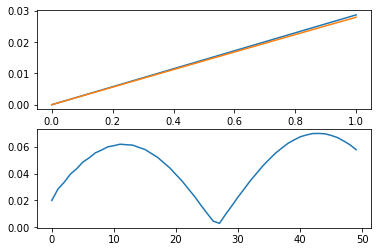

In [30]:
U = parabolicEquation2D(uxy0, ((ux0t, uxlt), (u0yt, ulyt)), 1)
showPostProcess(tt, yy)
Error(U, fResult)
plt.show()

Метод Дробных шагов

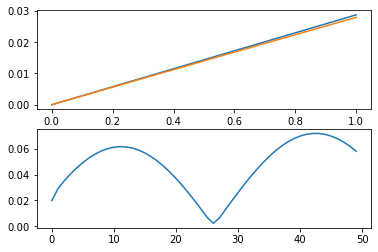

In [31]:
U = parabolicEquation2D(uxy0, ((ux0t, uxlt), (u0yt, ulyt)), 2)
showPostProcess(tt, yy)
Error(U, fResult)
plt.show()